In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1]


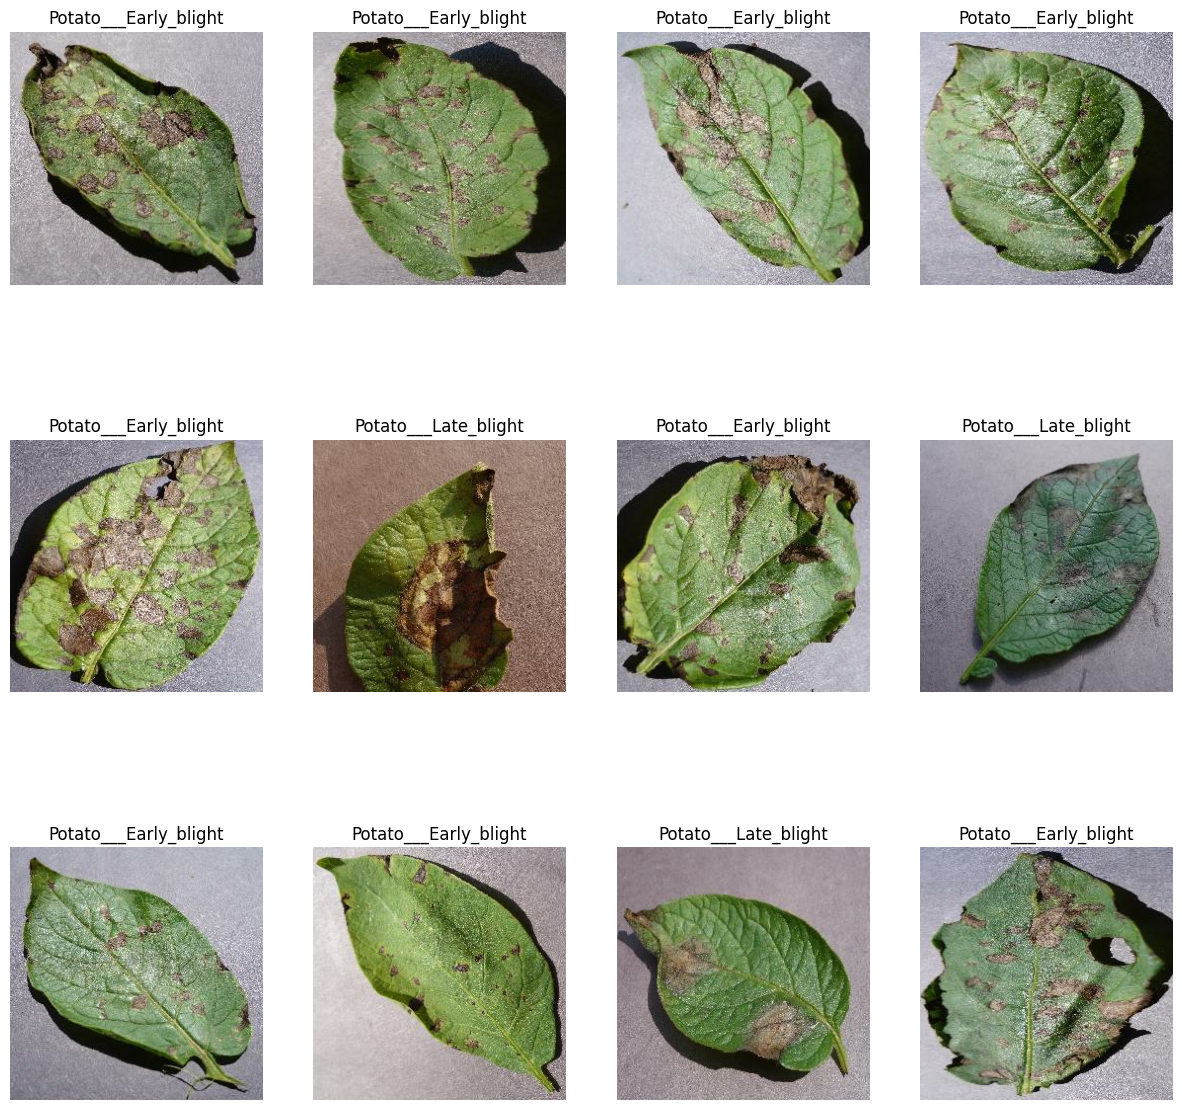

In [8]:
plt.figure (figsize=(15,15 ))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Train Test Validate Split

In [9]:
def train_test_valid_split(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(len(ds)*train_split)
    test_size=int(len(ds)*test_split)
    
    train_apl=dataset.take(train_size)
    temp_apl=dataset.skip(train_size)
    test_apl=temp_apl.take(test_size)
    val_apl=temp_apl.skip(test_size)
    return train_apl,test_apl,val_apl


In [10]:
train_apl,test_apl,val_apl=train_test_valid_split(dataset)

In [11]:
print(
len(train_apl),
len(test_apl),
len(val_apl)
)

54 6 8


In [12]:
train_apl = train_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_apl = val_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_apl = test_apl.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_n_scale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Modeling

In [15]:
CHANNELS


3

In [16]:
from tensorflow.keras.layers import Input, Add
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    """Define a ResNet residual block."""
    # Shortcut
    shortcut = x
    
    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # Adjusting the shortcut for addition
    if stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    
    return x

# Define the model with ResNet architecture
input_tensor = Input(shape=input_shape[1:])

x = resize_n_scale(input_tensor)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Using residual blocks
x = residual_block(x, 32)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64, stride=2)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(n_classes, activation='softmax')(x)

model2 = models.Model(inputs=input_tensor, outputs=output)


In [17]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['sequential[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 batch_normalization_8 (Bat  (None, 32, 32, 64)           256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 add_3 (Add)                 (None, 32, 32, 64)           0         ['batch_normalization_8[0][0]'
                                                                    , 'max_pooling2d_1[0][0]']    
                                                                                                  
 activation_7 (Activation)   (None, 32, 32, 64)           0         ['add_3[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)           0         ['activation_7[0][0]']        
 g2D)     

In [18]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model2.fit(
    train_apl,
    batch_size=BATCH_SIZE,
    validation_data=val_apl,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 185s 3s/step - loss: 1.9271 - accuracy: 0.7812 - val_loss: 1.0443 - val_accuracy: 0.4957
Epoch 2/5
54/54 [==============================] - 200s 4s/step - loss: 0.1864 - accuracy: 0.9340 - val_loss: 2.8383 - val_accuracy: 0.4655
Epoch 3/5
54/54 [==============================] - 210s 4s/step - loss: 0.0954 - accuracy: 0.9653 - val_loss: 4.6746 - val_accuracy: 0.4655
Epoch 4/5
54/54 [==============================] - 190s 4s/step - loss: 0.0602 - accuracy: 0.9815 - val_loss: 6.5566 - val_accuracy: 0.4655
Epoch 5/5
54/54 [==============================] - 191s 4s/step - loss: 0.0315 - accuracy: 0.9907 - val_loss: 7.9257 - val_accuracy: 0.4655


In [1]:
model2.evaluate(test_apl)

NameError: name 'model2' is not defined

import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model2.save(f"./models/{model_version}")

model2.save("./models/potato1")